# Time Diagrams

Tasks:

- plot rotation angle $\theta$ and rotation speed $\dot \theta$ against time
    - $\theta$ is measured both with sensor fusion (Oscillation in the AndroSensor app) and calculated from the magnometer readings
    - the rotation speed is measured with the gyroscope 
- fit the data to the equations of motion of a damped harmonic oscillator
- from the parameters obtained, determin the quality factor $Q_{f}$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit

In [2]:
def shift(arr, shift):
    """ Function to constrain the measurements in degrees inside a 0-360 range
    (it basically avoids the visual effect we get due to the arbitrary assignment 
    of 0 and 360 in the app)
    """
    res = []
    for v in arr:
        v += shift
        if v > 360:
            v -= 360
        if v < 0:
            v = 360 - abs(v)
        res.append(v)
    return np.array(res)

def time_to_rad(arr):
    """ Convert time values to radiants with a conversion: n_rad = t*step_rad*pi/step_time
        Time is in [ms]
    """
    step_rad = 0.5
    step_time = 10000
    return arr*step_rad*np.pi/step_time

def shift_min_to_zero(arr):
    shift = np.amin(arr)
    return arr - shift

In [3]:
def general_damped_sinusoid(t, amp, dec, ang_freq, phase, shift):
    return amp * np.exp(-dec*t) * (np.cos(ang_freq*t+phase)+np.sin(ang_freq*t+phase)) + shift

In [4]:
# Remember to delete first row from the file
input_file = "data/1_surface.csv"

In [5]:
dataset = pd.read_csv(input_file, sep=";")

In [6]:
dataset

,ACCELEROMETER X (m/s²),ACCELEROMETER Y (m/s²),ACCELEROMETER Z (m/s²),GRAVITY X (m/s²),GRAVITY Y (m/s²),GRAVITY Z (m/s²),LINEAR ACCELERATION X (m/s²),LINEAR ACCELERATION Y (m/s²),LINEAR ACCELERATION Z (m/s²),GYROSCOPE X (rad/s),GYROSCOPE Y (rad/s),GYROSCOPE Z (rad/s),MAGNETIC FIELD X (μT),MAGNETIC FIELD Y (μT),MAGNETIC FIELD Z (μT),ORIENTATION Z (azimuth °),ORIENTATION X (pitch °),ORIENTATION Y (roll °),Time since start in ms,YYYY-MO-DD HH-MI-SS_SSS
0,-0.27773,-0.07901,9.91678,-0.30342,-0.20425,9.79983,0.03048,0.09651,-0.63961,0.10263,0.06597,-0.80817,-18.12,-4.38,-33.42,103.813,1.193,1.773,26,2021-02-11 21:49:46:533
1,-0.27773,-0.07901,9.91678,-0.32377,-0.15703,9.80005,0.02929,0.03732,0.25560,0.10263,0.06597,-0.80817,-17.52,-5.22,-33.84,106.148,0.917,1.892,74,2021-02-11 21:49:46:581
2,-0.26815,-0.39983,9.90242,-0.32377,-0.15703,9.80005,0.02929,0.03732,0.25560,0.10263,0.06597,-0.80817,-17.52,-5.22,-33.84,106.148,0.917,1.892,123,2021-02-11 21:49:46:630
3,-0.26815,-0.39983,9.90242,-0.35759,-0.11454,9.79946,0.06071,-0.03629,0.11972,0.07330,0.04704,-1.00060,-17.52,-5.22,-33.84,106.148,0.917,1.892,174,2021-02-11 21:49:46:681
4,-0.27294,-0.41659,10.01016,-0.35759,-0.11454,9.79946,0.06071,-0.03629,0.11972,0.07330,0.04704,-1.00060,-16.02,-7.98,-33.66,115.963,0.669,2.090,224,2021-02-11 21:49:46:731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,-0.25857,-0.33279,9.82820,-0.19362,-0.29421,9.80032,-0.12481,-0.08168,0.05421,-0.04215,-0.03910,0.00733,18.78,4.74,-34.50,282.214,1.719,1.132,17323,2021-02-11 21:50:03:830
347,-0.19154,-0.36152,9.83538,-0.18133,-0.31133,9.80003,-0.01020,-0.05020,0.03535,-0.05559,-0.06292,-0.02382,18.78,4.74,-34.50,282.214,1.719,1.132,17373,2021-02-11 21:50:03:880
348,0.14844,-0.26576,10.02931,-0.18133,-0.31133,9.80003,-0.01020,-0.05020,0.03535,-0.05559,-0.06292,-0.02382,19.80,5.28,-34.14,281.404,1.819,1.060,17423,2021-02-11 21:50:03:930
349,0.14844,-0.26576,10.02931,-0.09363,-0.34620,9.80009,0.01702,0.02537,0.20528,-0.05559,-0.06292,-0.02382,19.80,5.28,-34.14,281.404,1.819,1.060,17473,2021-02-11 21:50:03:980


### Sensor Fusion

From the description in the app, we see that Z already measures the angle relative to the north pole.

For what concerns the uncertainty, we proceed like follows:

- sensor fusion measurement is computed from values of accelerometer and magnetometer
- the app gives the accuracy for both these measurements; we use an approximation of that as an estimate of the uncertainty;
- we compute the final $\frac{\delta q}{q}$ with the quadratic sum of the relative uncertainties on the three axes

For the quality factor (which represents the number of oscillations performed before these become negligible) we use the formula for weakly damped oscillators $Q_f = \frac{\omega}{\nu}$

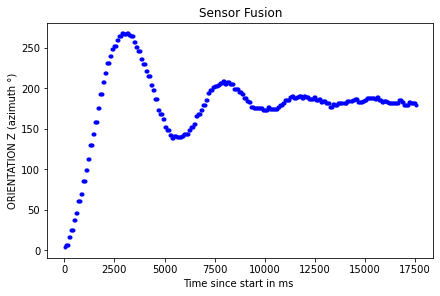

In [7]:
# Plot the result
t = dataset['Time since start in ms ']

dataset['orientation_z_shift'] = shift(dataset['ORIENTATION Z (azimuth °)'], -100)
degrees = dataset['orientation_z_shift']

fig, ax = plt.subplots(constrained_layout=True)
ax.set_title('Sensor Fusion')
ax.set_xlabel('Time since start in ms ')
ax.set_ylabel('ORIENTATION Z (azimuth °)')
plt.plot(t, degrees, marker='.', linestyle='', color='b')
plt.show();

In [8]:
# Compute the uncertainties and plot again
accel_accuracy = 0.002
mag_accuracy = 0.06
dataset = dataset.assign(
    sf_unc=np.sqrt(
        (accel_accuracy/dataset['ACCELEROMETER X (m/s²)'])**2
        + (mag_accuracy/dataset['MAGNETIC FIELD Z (μT)'])**2
    ) 
    * dataset['ORIENTATION Z (azimuth °)']
)

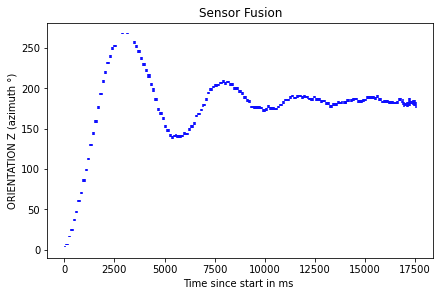

In [9]:
yerr = dataset['sf_unc']

fig, ax = plt.subplots(constrained_layout=True)
ax.set_title('Sensor Fusion')
ax.set_xlabel('Time since start in ms ')
ax.set_ylabel('ORIENTATION Z (azimuth °)')
plt.errorbar(t, degrees, yerr=yerr, linestyle='', color='b')
plt.show();

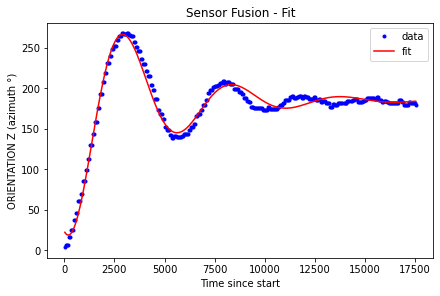

Amplitude = -127.08431093924018 +/- 1.5239590337687792
Decay Constant = 1.6750884747003127 +/- 0.031289693786939944
Angular Frequency = 7.3765343233096825 +/- 0.03915534621848627
Phase = -175.59404877828968 +/- 0.018827112556248502
Shift = 185.1310163323213 +/- 0.4637615279070247
Quality factor = 2.20183424180905 +/- 0.04275738096357672


In [26]:
# Perform fit

dataset['time_in_rad'] = time_to_rad(dataset['Time since start in ms '])
rad_t = dataset['time_in_rad']

# Fit only between 0 and 1.5 rad
rad_t_range = dataset['time_in_rad'][dataset['time_in_rad'] < 2.4]
degrees_range = dataset['orientation_z_shift'][dataset['time_in_rad'] < 2.4]

parameters = ['Amplitude', 'Decay Constant', 'Angular Frequency', 'Phase', 'Shift']
params = {}
popt, pcov = curve_fit(general_damped_sinusoid, rad_t_range, degrees_range, maxfev=100000)
stdevm = np.sqrt(np.diag(pcov))
for name, val, unc in zip(parameters, popt, stdevm):
    params[name] = {}
    params[name]['value'] = val
    params[name]['uncert'] = unc

pred_degrees = general_damped_sinusoid(rad_t, *[p['value'] for p in params.values()])

fig, ax = plt.subplots(constrained_layout=True)
ax.set_title('Sensor Fusion - Fit')
ax.set_xlabel('Time since start')
ax.set_ylabel('ORIENTATION Z (azimuth °)')
plt.plot(t, degrees, marker='.', linestyle='', color='b', label='data')
plt.plot(t, pred_degrees, color='r', label='fit')
plt.legend()
plt.show();

for k, v in params.items():
    print('{} = {} +/- {}'.format(k, v['value'], v['uncert']))

ang_freq = params['Angular Frequency']['value']
dec_con = params['Decay Constant']['value']
ang_freq_u = params['Angular Frequency']['uncert']
dec_con_u = params['Decay Constant']['uncert']
qf = ang_freq / (2 * dec_con)
qf_u = math.sqrt((ang_freq_u/ang_freq)**2 + (dec_con_u/dec_con)**2) * qf
print("Quality factor = {} +/- {}".format(qf, qf_u))

### Magnetometer

Considering that the component fo the magnetic field along the Z axis is almost irrelevant, an acceptable solution consists in measuring the angle between the projection of the magnetic field on the phone plane and one of the axes of the plane.
In this case we choose Y.

In [27]:
# DO NOT RUN
# In principle this is the correct formula to return the angle between a vector (Earth magnetic field) and a plane (the phone)

dataset = dataset.assign(
    computed_angle=np.arccos(
        (
            dataset['MAGNETIC FIELD X (μT)'] 
            + dataset['MAGNETIC FIELD Y (μT)']
            + dataset['MAGNETIC FIELD Z (μT)']
        ) 
        / (np.sqrt(
            dataset['MAGNETIC FIELD X (μT)']**2
            + dataset['MAGNETIC FIELD Y (μT)']**2
            + dataset['MAGNETIC FIELD Z (μT)']**2
        ) * math.sqrt(3))  
    )
)

In [28]:
dataset = dataset.assign(
    computed_angle_on_plane=np.arcsin(
        dataset['MAGNETIC FIELD Y (μT)'] /
        np.sqrt(dataset['MAGNETIC FIELD Y (μT)']**2 + dataset['MAGNETIC FIELD X (μT)']**2)
    )
)

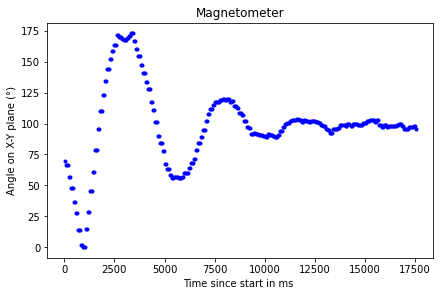

In [30]:
# Plot the result
angle_plane = [math.degrees(ang) for ang in dataset['computed_angle_on_plane']]
angle_plane = shift_min_to_zero(angle_plane)
dataset['angle_plane_shift'] = angle_plane

fig, ax = plt.subplots(constrained_layout=True)
ax.set_title('Magnetometer')
ax.set_xlabel('Time since start in ms ')
ax.set_ylabel('Angle on X-Y plane (°)')
plt.plot(t, angle_plane, marker='.', linestyle='', color='b')
plt.show();

In [31]:
# Compute the uncertainties and plot again
mag_accuracy = 0.06
dataset = dataset.assign(
    angle_on_plane_unc=np.sqrt(
        (mag_accuracy/dataset['MAGNETIC FIELD X (μT)'])**2
        + (mag_accuracy/dataset['MAGNETIC FIELD Y (μT)'])**2
    ) 
    * dataset['computed_angle_on_plane']
)

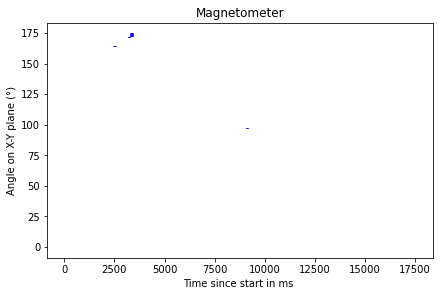

In [32]:
yerr = dataset['angle_on_plane_unc']

fig, ax = plt.subplots(constrained_layout=True)
ax.set_title('Magnetometer')
ax.set_xlabel('Time since start in ms ')
ax.set_ylabel('Angle on X-Y plane (°)')
plt.errorbar(t, angle_plane, yerr=yerr, linestyle='', color='b')
plt.show();

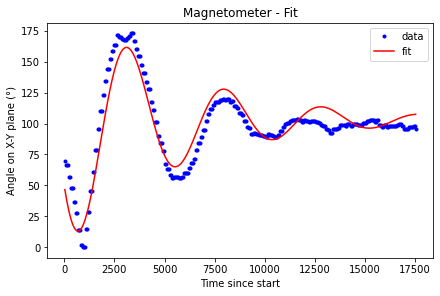

Amplitude = 72.56808299370633 +/- 2.169641674870918
Decay Constant = 1.131431604043344 +/- 0.051252221333155136
Angular Frequency = 8.257228472605197 +/- 0.0567811464217842
Phase = -3.373588389308493 +/- 0.036472529490907714
Shift = 103.11919021049498 +/- 0.6842328629643818
Quality factor = 3.6490179534921627 +/- 0.1671889964770968


In [36]:
# Perform fit

# Fit only between 0 and 1.5 rad
rad_t_range = dataset['time_in_rad'][dataset['time_in_rad'] < 2.5]
angle_plane_range = dataset['angle_plane_shift'][dataset['time_in_rad'] < 2.5]

parameters = ['Amplitude', 'Decay Constant', 'Angular Frequency', 'Phase', 'Shift']
params = {}
popt, pcov = curve_fit(general_damped_sinusoid, rad_t_range, angle_plane_range, maxfev=100000)
stdevm = np.sqrt(np.diag(pcov))
for name, val, unc in zip(parameters, popt, stdevm):
    params[name] = {}
    params[name]['value'] = val
    params[name]['uncert'] = unc

pred_angle = general_damped_sinusoid(rad_t, *[p['value'] for p in params.values()])

fig, ax = plt.subplots(constrained_layout=True)
ax.set_title('Magnetometer - Fit')
ax.set_xlabel('Time since start')
ax.set_ylabel('Angle on X-Y plane (°)')
plt.plot(t, angle_plane, marker='.', linestyle='', color='b', label='data')
plt.plot(t, pred_angle, color='r', label='fit')
plt.legend()
plt.show();

for k, v in params.items():
    print('{} = {} +/- {}'.format(k, v['value'], v['uncert']))

ang_freq = params['Angular Frequency']['value']
dec_con = params['Decay Constant']['value']
ang_freq_u = params['Angular Frequency']['uncert']
dec_con_u = params['Decay Constant']['uncert']
qf = ang_freq / (2 * dec_con)
qf_u = math.sqrt((ang_freq_u/ang_freq)**2 + (dec_con_u/dec_con)**2) * qf
print("Quality factor = {} +/- {}".format(qf, qf_u))

### Gyroscope

The app says the accuracy is 0.00061086525

We use 0.001 as a systematic uncertainty

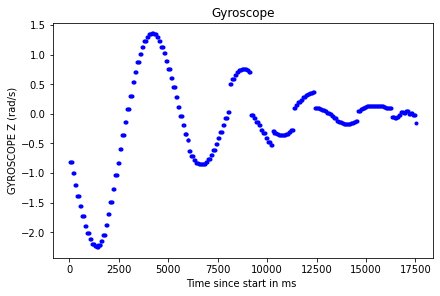

In [37]:
# Plot the result
rad_vel = dataset['GYROSCOPE Z (rad/s)']

fig, ax = plt.subplots(constrained_layout=True)
ax.set_title('Gyroscope')
ax.set_xlabel('Time since start in ms ')
ax.set_ylabel('GYROSCOPE Z (rad/s)')
plt.plot(t, rad_vel, marker='.', linestyle='', color='b')
plt.show();

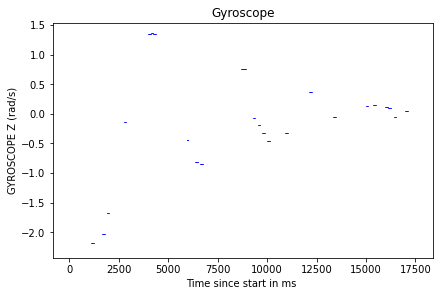

In [38]:
# Plot with uncertainties
gyr_accuracy = 0.001

fig, ax = plt.subplots(constrained_layout=True)
ax.set_title('Gyroscope')
ax.set_xlabel('Time since start in ms ')
ax.set_ylabel('GYROSCOPE Z (rad/s)')
plt.errorbar(t, rad_vel, yerr=gyr_accuracy, linestyle='', color='b')
plt.show();

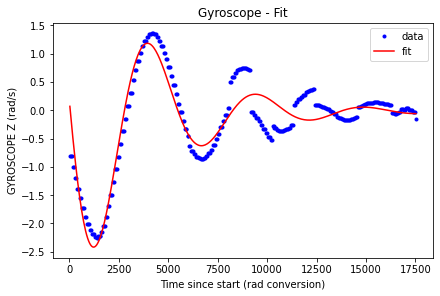

Amplitude = -2.36275158501728 +/- 0.08609915537587758
Decay Constant = 1.6067535580806722 +/- 0.07607477666056364
Angular Frequency = 7.336876156789517 +/- 0.06420477313103351
Phase = -0.8426379698124173 +/- 0.028151443971072422
Shift = -0.021496485748427416 +/- 0.017912842118517357
Quality factor = 2.283136738640147 +/- 0.109930295918467


In [40]:
# Perform fit

# Fit only between 0 and 1.5 rad
rad_t_range = dataset['time_in_rad'][dataset['time_in_rad'] < 2.5]
rad_vel_range = dataset['GYROSCOPE Z (rad/s)'][dataset['time_in_rad'] < 2.5]

parameters = ['Amplitude', 'Decay Constant', 'Angular Frequency', 'Phase', 'Shift']
params = {}
popt, pcov = curve_fit(general_damped_sinusoid, rad_t_range, rad_vel_range, maxfev=100000)
stdevm = np.sqrt(np.diag(pcov))
for name, val, unc in zip(parameters, popt, stdevm):
    params[name] = {}
    params[name]['value'] = val
    params[name]['uncert'] = unc

pred_rad_vel = general_damped_sinusoid(rad_t, *[p['value'] for p in params.values()])

fig, ax = plt.subplots(constrained_layout=True)
ax.set_title('Gyroscope - Fit')
ax.set_xlabel('Time since start (rad conversion)')
ax.set_ylabel('GYROSCOPE Z (rad/s)')
plt.plot(t, rad_vel, marker='.', linestyle='', color='b', label='data')
plt.plot(t, pred_rad_vel, color='r', label='fit')
plt.legend()
plt.show();

for k, v in params.items():
    print('{} = {} +/- {}'.format(k, v['value'], v['uncert']))

ang_freq = params['Angular Frequency']['value']
dec_con = params['Decay Constant']['value']
ang_freq_u = params['Angular Frequency']['uncert']
dec_con_u = params['Decay Constant']['uncert']
qf = ang_freq / (2 * dec_con)
qf_u = math.sqrt((ang_freq_u/ang_freq)**2 + (dec_con_u/dec_con)**2) * qf
print("Quality factor = {} +/- {}".format(qf, qf_u))